Install Dependencies

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg
!pip install 'imageio==2.4.0'
!pip install matplotlib
!pip install tf-agents[reverb]
!pip install pybullet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,165 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,287 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,264 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubunt

## Setup

Imports

In [ ]:
import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import os
import reverb
import tempfile
import PIL.Image

import tensorflow as tf



from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.environments import suite_pybullet
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.train import actor
from tf_agents.train import learner
from tf_agents.train import triggers
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import strategy_utils
from tf_agents.train.utils import train_utils

tempdir = tempfile.gettempdir()

## Hyperparameters

In [ ]:
env_name = "MinitaurBulletEnv-v0"

# Use "num_iterations = 1e6" for better results (2 hrs)
# 1e5 is just so this doesn't take too long (1 hr)
num_iterations = 100000

initial_collect_steps = 10000
collect_steps_per_iteration = 1
replay_buffer_capacity = 10000

batch_size = 256

critic_learning_rate = 3e-4
actor_learning_rate = 3e-4
alpha_learning_rate = 3e-4
target_update_tau = 0.005
target_update_period = 1
gamma = 0.99
reward_scale_factor = 1.0

actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)

log_interval = 5000

num_eval_episodes = 20
eval_interval = 10000

policy_save_interval = 5000

## Environment


Take a pic of Enviroment

urdf_root=/usr/local/lib/python3.10/dist-packages/pybullet_data


/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


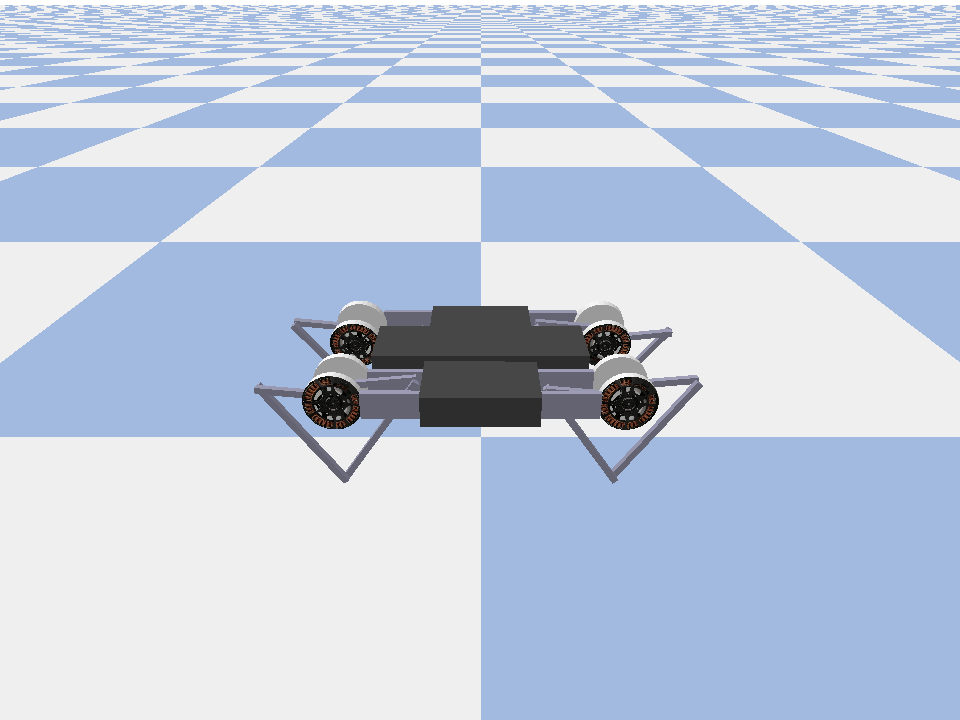

In [ ]:
env = suite_pybullet.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

In this environment the goal is for the agent to train a policy that will move the Minitaur robot as fast as possible. Episodes last 1000 steps and the return will be the sum of rewards throughout the episode.

Let's look at  `observation` Spec.

In [ ]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(28,), dtype=dtype('float32'), name='observation', minimum=[  -3.1515927   -3.1515927   -3.1515927   -3.1515927   -3.1515927
   -3.1515927   -3.1515927   -3.1515927 -167.72488   -167.72488
 -167.72488   -167.72488   -167.72488   -167.72488   -167.72488
 -167.72488     -5.71        -5.71        -5.71        -5.71
   -5.71        -5.71        -5.71        -5.71        -1.01
   -1.01        -1.01        -1.01     ], maximum=[  3.1515927   3.1515927   3.1515927   3.1515927   3.1515927   3.1515927
   3.1515927   3.1515927 167.72488   167.72488   167.72488   167.72488
 167.72488   167.72488   167.72488   167.72488     5.71        5.71
   5.71        5.71        5.71        5.71        5.71        5.71
   1.01        1.01        1.01        1.01     ])
Action Spec:
BoundedArraySpec(shape=(8,), dtype=dtype('float32'), name='action', minimum=-1.0, maximum=1.0)


We receive 28 values representing the angles, velocities, and torques for all the motors. In return the environment expects 8 values for the actions between `[-1, 1]`. These are the desired motor angles.

We create two environments: one for collecting data during training and one for evaluation.

In [ ]:
collect_env = suite_pybullet.load(env_name)
eval_env = suite_pybullet.load(env_name)

urdf_root=/usr/local/lib/python3.10/dist-packages/pybullet_data
urdf_root=/usr/local/lib/python3.10/dist-packages/pybullet_data


### Enabling the GPU
If you want to run on a GPU, you'll first need to enable GPUs for the notebook:

* Go to Edit, Notebook Settings
* Select GPU from the Hardware Accelerator


* `use_gpu = False` returns `tf.distribute.get_strategy()`, which uses CPU
* `use_gpu = True` returns `tf.distribute.MirroredStrategy()`, which uses all GPUs that are visible to TensorFlow on one machine

In [ ]:
use_gpu = True

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

## Agent

SAC is an actor-critic agent, so we will need two networks.

The critic will give us value estimates for `Q(s,a)`. That is, it will recieve as input an observation and an action, and it will give us an estimate of how good that action was for the given state.


In [ ]:
observation_spec, action_spec, time_step_spec = (
      spec_utils.get_tensor_specs(collect_env))

with strategy.scope():
  critic_net = critic_network.CriticNetwork(
        (observation_spec, action_spec),
        observation_fc_layer_params=None,
        action_fc_layer_params=None,
        joint_fc_layer_params=critic_joint_fc_layer_params,
        kernel_initializer='glorot_uniform',
        last_kernel_initializer='glorot_uniform')

We will use this critic to train an `actor` network which will allow us to generate actions given an observation.

The `ActorNetwork` will predict parameters for a tanh distribution. This distribution will then be sampled, conditioned on the current observation, whenever we need to generate actions.

In [ ]:
with strategy.scope():
  actor_net = actor_distribution_network.ActorDistributionNetwork(
      observation_spec,
      action_spec,
      fc_layer_params=actor_fc_layer_params,
      continuous_projection_net=(
          tanh_normal_projection_network.TanhNormalProjectionNetwork))

With the actor and critic networks created we can now instantiate the agent.


In [ ]:
with strategy.scope():
  train_step = train_utils.create_train_step()

  tf_agent = sac_agent.SacAgent(
        time_step_spec,
        action_spec,
        actor_network=actor_net,
        critic_network=critic_net,
        actor_optimizer=tf.keras.optimizers.Adam(
            learning_rate=actor_learning_rate),
        critic_optimizer=tf.keras.optimizers.Adam(
            learning_rate=critic_learning_rate),
        alpha_optimizer=tf.keras.optimizers.Adam(
            learning_rate=alpha_learning_rate),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        td_errors_loss_fn=tf.math.squared_difference,
        gamma=gamma,
        reward_scale_factor=reward_scale_factor,
        train_step_counter=train_step)

  tf_agent.initialize()

## Replay Buffer

In order to keep track of the data collected from the environment, we will use [Reverb] easy-to-use replay system by Deepmind.



In [ ]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

The replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using `tf_agent.collect_data_spec`.

Since the SAC Agent needs both the current and next observation to compute the loss, we set `sequence_length=2`.

In [ ]:
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server)

Now we generate a TensorFlow dataset from the Reverb replay buffer. We will pass this to the Learner to sample experiences for training.

In [ ]:
dataset = reverb_replay.as_dataset(
      sample_batch_size=batch_size, num_steps=2).prefetch(50)
experience_dataset_fn = lambda: dataset

## Policies

In TF-Agents, policies represent the standard notion of policies in RL: given a `time_step` produce an action or a distribution over actions. The main method is `policy_step = policy.step(time_step)` where `policy_step` is a named tuple `PolicyStep(action, state, info)`.  The `policy_step.action` is the `action` to be applied to the environment, `state` represents the state for stateful (RNN) policies and `info` may contain auxiliary information such as log probabilities of the actions.

Agents contain two policies:

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.

In [ ]:
tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)

In [ ]:
tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

Policies can be created independently of agents. For example, use `tf_agents.policies.random_py_policy` to create a policy which will randomly select an action for each time_step.

In [ ]:
random_policy = random_py_policy.RandomPyPolicy(
  collect_env.time_step_spec(), collect_env.action_spec())

## Actors
The actor manages interactions between a policy and an environment.
  * The Actor components contain an instance of the environment (as `py_environment`) and a copy of the policy variables.
  * Each Actor worker runs a sequence of data collection steps given the local values of the policy variables.
  * Variable updates are done explicitly using the variable container client instance in the training script before calling `actor.run()`.
  * The observed experience is written into the replay buffer in each data collection step.

As the Actors run data collection steps, they pass trajectories of (state, action, reward) to the observer, which caches and writes them to the Reverb replay system.

We're storing trajectories for frames [(t0,t1) (t1,t2) (t2,t3), ...] because `stride_length=1`.

In [ ]:
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  reverb_replay.py_client,
  table_name,
  sequence_length=2,
  stride_length=1)

We create an Actor with the random policy and collect experiences to seed the replay buffer with.

In [ ]:
initial_collect_actor = actor.Actor(
  collect_env,
  random_policy,
  train_step,
  steps_per_run=initial_collect_steps,
  observers=[rb_observer])
initial_collect_actor.run()

Instantiate an Actor with the collect policy to gather more experiences during training.

In [ ]:
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
  collect_env,
  collect_policy,
  train_step,
  steps_per_run=1,
  metrics=actor.collect_metrics(10),
  summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
  observers=[rb_observer, env_step_metric])

Create an Actor which will be used to evaluate the policy during training. We pass in `actor.eval_metrics(num_eval_episodes)` to log metrics later.

In [ ]:
eval_actor = actor.Actor(
  eval_env,
  eval_policy,
  train_step,
  episodes_per_run=num_eval_episodes,
  metrics=actor.eval_metrics(num_eval_episodes),
  summary_dir=os.path.join(tempdir, 'eval'),
)

## Learners
The Learner component contains the agent and performs gradient step updates to the policy variables using experience data from the replay buffer. After one or more training steps, the Learner can push a new set of variable values to the variable container.

In [ ]:
saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        tf_agent,
        train_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(train_step, interval=1000),
]

agent_learner = learner.Learner(
  tempdir,
  train_step,
  tf_agent,
  experience_dataset_fn,
  triggers=learning_triggers,
  strategy=strategy)

## Metrics and Evaluation

We instantiated the eval Actor with `actor.eval_metrics` above, which creates most commonly used metrics during policy evaluation:
* Average return. The return is the sum of rewards obtained while running a policy in an environment for an episode, and we usually average this over a few episodes.
* Average episode length.


In [ ]:
def get_eval_metrics():
  eval_actor.run()
  results = {}
  for metric in eval_actor.metrics:
    results[metric.name] = metric.result()
  return results

metrics = get_eval_metrics()

In [ ]:
def log_eval_metrics(step, metrics):
  eval_results = (', ').join(
      '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
  print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

step = 0: AverageReturn = 1.553387, AverageEpisodeLength = 496.950012


## Training the agent

The training loop involves both collecting data from the environment and optimizing the agent's networks. Along the way, we will return evaluations of the agent's policy.

In [ ]:

try:
  %%time
except:
  pass

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = get_eval_metrics()["AverageReturn"]
returns = [avg_return]

for _ in range(num_iterations):
  # Training.
  collect_actor.run()
  loss_info = agent_learner.run(iterations=1)

  # Evaluating.
  step = agent_learner.train_step_numpy

  if eval_interval and step % eval_interval == 0:
    metrics = get_eval_metrics()
    log_eval_metrics(step, metrics)
    returns.append(metrics["AverageReturn"])

  if log_interval and step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))

rb_observer.close()
reverb_server.stop()

step = 5000: loss = -61.323753356933594
step = 10000: AverageReturn = -0.732125, AverageEpisodeLength = 228.949997
step = 10000: loss = -54.074066162109375
step = 15000: loss = -34.89334487915039
step = 20000: AverageReturn = -0.241355, AverageEpisodeLength = 141.850006
step = 20000: loss = -20.765148162841797
step = 25000: loss = -14.475028991699219
step = 30000: AverageReturn = -1.045532, AverageEpisodeLength = 385.850006
step = 30000: loss = -8.732686042785645
step = 35000: loss = -3.6120145320892334
step = 40000: AverageReturn = -1.364033, AverageEpisodeLength = 422.399994
step = 40000: loss = -2.635775089263916
step = 45000: loss = -0.3149372339248657
step = 50000: AverageReturn = -0.850398, AverageEpisodeLength = 415.649994
step = 50000: loss = -2.125321388244629
step = 55000: loss = -1.4739015102386475
step = 60000: AverageReturn = -1.180684, AverageEpisodeLength = 486.399994
step = 60000: loss = 0.4254522919654846
step = 65000: loss = -1.7865054607391357
step = 70000: AverageRe

## Visualization


### Plots

We can plot average return vs global steps to see the performance of our agent. In `Minitaur`, the reward function is based on how far the minitaur walks in 1000 steps and penalizes the energy expenditure.

(-1.5139240026474, 1.7836757898330688)

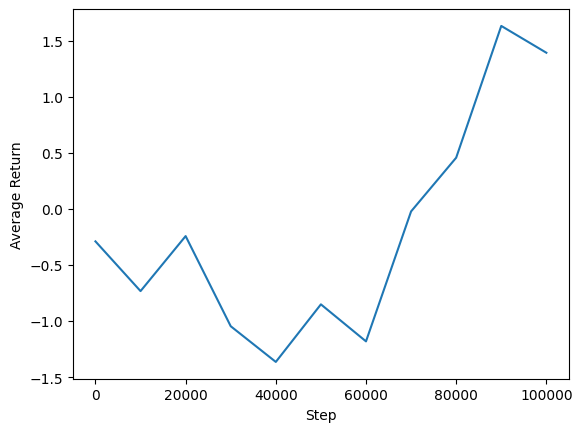

In [ ]:


steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim()

### Videos

It is helpful to visualize the performance of an agent by rendering the environment at each step. Before we do that, let us first create a function to embed videos in this colab.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

The following code visualizes the agent's policy for a few episodes:

In [ ]:
num_episodes = 3
video_filename = 'sac_minitaur.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_env.render())
    while not time_step.is_last():
      action_step = eval_actor.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_env.render())

embed_mp4(video_filename)